In [1]:
import copy
import onnx
import torch
import numpy as np
from matplotlib import pyplot as plt
from StarV.set.star import Star
from StarV.layer.FullyConnectedLayer import FullyConnectedLayer
from StarV.util.load import load_neural_network
from StarV.util.plot import plot_star2D
from StarV.verifier.certifier import reachBFS
from StarV.layer.ReLULayer import ReLULayer

In [2]:
def sample_plot(sample):
    n = sample.shape[1]
    for i in range(n):
        plt.plot(sample[0, i], sample[1, i], '*k')
    plt.show()

In [3]:
"""
STEP 1: CREATE MODEL CLASS
"""
class ReLUFFNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [4]:
"""
STEP 2: INITIATE MODEL CLASS
"""
input_dim = 2
hidden_dim = 2
output_dim = 2

network_model = ReLUFFNNModel(input_dim, hidden_dim, output_dim)

print('network_model:\n', network_model)
input = torch.randn(input_dim)

print('input: ', input)

output = network_model(input)
print('output: ', output)

network_model:
 ReLUFFNNModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=2, out_features=2, bias=True)
)
input:  tensor([1.4319, 0.8265])
output:  tensor([-0.1104,  0.6207], grad_fn=<AddBackward0>)


Star Set:
V:
[[0. 1. 0.]
 [0. 0. 1.]]
Predicate Constraints:
C:
[]
d: []
dim: 2
nVars: 2
pred_lb: [1.42194 0.81652]
pred_ub: [1.44194 0.83652]


Star Set:
V: (2, 3)
Predicate Constraints:
C: (0,)
d: (0,)
dim: 2
nVars: 2
pred_lb: (2,)
pred_ub: (2,)



Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-06
lower bounds:  [1.42194 0.81652]
upper bounds:  [1.44194 0.83652]


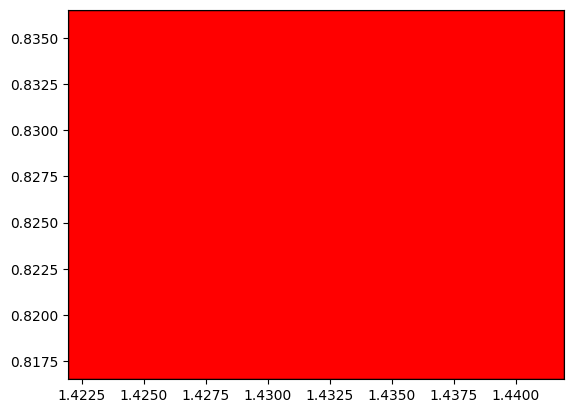

<Axes: >

In [5]:
"""
STEP 3: IFINITY NORM ATTACK
"""

epsilon = 0.01
x = input.numpy()

"""
Create Star set with given input and epsilon by applying infinity norm attack.
A 2D polyhedra in a star set representation.
"""
X = Star.inf_attack(x, epsilon)

# prints attributes in Star set 
print(X)
# prints shape or dimension of attributes in Star set
repr(X)

print('\n')
#lower and upper bounds of initial Star set
lb, ub = X.getRanges()
print('lower bounds: ', lb)
print('upper bounds: ', ub)

plot_star2D(X)

In [6]:
"""
STEP 4: CONVERT PYTORCH NEURAL NETWORK TO STARV NEURAL NETWORK
"""

display = True
network_name = 'ReLU FFNN'
StarV_network = load_neural_network(network_model, network_name, display)
print('\n')

StarV_network.info()
print('\n')

for i in range(StarV_network.n_layers):
    print('Layer {}: {}'.format(i, type(StarV_network.layers[i])))
    if isinstance(StarV_network.layers[i], FullyConnectedLayer):
        print('Weights:\n {}'.format(StarV_network.layers[i].W))
        print('Bias:\n {}'.format(StarV_network.layers[i].b))

converting to StarV module
layer:  Linear(in_features=2, out_features=2, bias=True)
layer:  ReLU()
layer:  Linear(in_features=2, out_features=2, bias=True)
layer:  ReLU()
layer:  Linear(in_features=2, out_features=2, bias=True)


Network Information:
Network type: ReLU FFNN
Input Dimension: 2
Output Dimension: 2
Number of Layers: 5
Layer types:
Layer 0: <class 'StarV.layer.FullyConnectedLayer.FullyConnectedLayer'> (2, 2)
Layer 1: <class 'StarV.layer.ReLULayer.ReLULayer'>
Layer 2: <class 'StarV.layer.FullyConnectedLayer.FullyConnectedLayer'> (2, 2)
Layer 3: <class 'StarV.layer.ReLULayer.ReLULayer'>
Layer 4: <class 'StarV.layer.FullyConnectedLayer.FullyConnectedLayer'> (2, 2)


Layer 0: <class 'StarV.layer.FullyConnectedLayer.FullyConnectedLayer'>
Weights:
 [[-0.15696 -0.16503]
 [-0.47145  0.4871 ]]
Bias:
 [-0.1844  -0.40431]
Layer 1: <class 'StarV.layer.ReLULayer.ReLULayer'>
Layer 2: <class 'StarV.layer.FullyConnectedLayer.FullyConnectedLayer'>
Weights:
 [[ 0.57684 -0.68014]
 [-0.40434 

In [7]:
# single input
output = StarV_network.evaluate(x)
print('input: ', x)
print('output: ', output)

input:  [1.43194 0.82652]
output:  [-0.11045  0.62072]


Input Star Set:
 


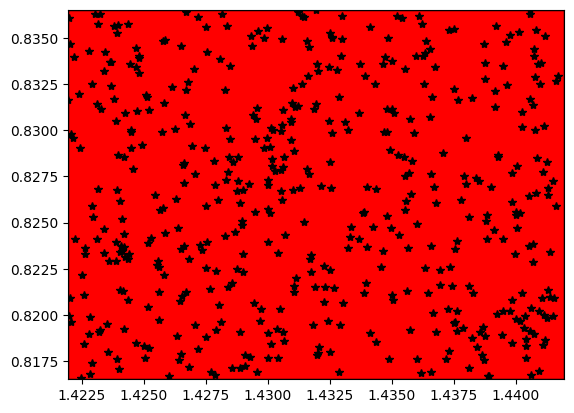

Layer 0: <class 'StarV.layer.FullyConnectedLayer.FullyConnectedLayer'>
Weights:
 [[-0.15696 -0.16503]
 [-0.47145  0.4871 ]]
Bias:
 [-0.1844  -0.40431]

Star Set:
V:
[[-0.1844  -0.15696 -0.16503]
 [-0.40431 -0.47145  0.4871 ]]
Predicate Constraints:
C:
[]
d: []
dim: 2
nVars: 2
pred_lb: [1.42194 0.81652]
pred_ub: [1.44194 0.83652]




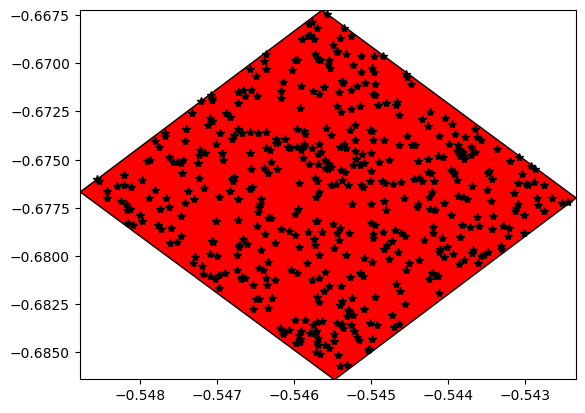

Layer 1: <class 'StarV.layer.ReLULayer.ReLULayer'>


AttributeError: type object 'PosLin' has no attribute 'reachApprox'

In [8]:
"""
STEP 5: LAYER-BY-LAYER OVER-APPROXIMATE REACHABILITY ANALYSIS
"""

reachMethod='approx'
lp_solver='gurobi'
show = True

H = copy.deepcopy(X)

n_sample = 500
sample = X.sample(n_sample)

print('Input Star Set:\n ')
plot_star2D(X, show=False)
sample_plot(sample)

for i in range(StarV_network.n_layers):
    print('Layer {}: {}'.format(i, type(StarV_network.layers[i])))
    if isinstance(StarV_network.layers[i], FullyConnectedLayer):
        print('Weights:\n {}'.format(StarV_network.layers[i].W))
        print('Bias:\n {}\n'.format(StarV_network.layers[i].b))

    H = StarV_network.layers[i].reach(H, reachMethod, lp_solver, show=show)
    
    print(H)
    plot_star2D(H, show=False)
    sample = StarV_network.layers[i].evaluate(sample)
    sample_plot(sample)

In [ ]:
"""
STEP 6: COMPUTE OVER-APPROXIMATE OUTPUT REACHABLE SET
"""
reachMethod='approx'
lp_solver='gurobi'
show = True

StarV_network.info()
print('\n')

In = copy.deepcopy(X)

outputSet, totalReachTime = reachBFS(StarV_network, In, reachMethod, lp_solver, show=show)

n_sample = 500
sample = X.sample(n_sample)
plot_star2D(outputSet, show=False)
sample = StarV_network.evaluate(sample)
sample_plot(sample)

In [ ]:
"""
STEP 6: COMPUTE EXACT OUTPUT REACHABLE SET
"""
reachMethod='exact'
lp_solver='gurobi'
show = True

StarV_network.info()
print('\n')

In = [copy.deepcopy(X)]
outputSet, totalReachTime = reachBFS(StarV_network, In, reachMethod, lp_solver, show=show)

print('\nNumber of output star sets: ', len(outputSet))
for i in range(len(outputSet)):
    plot_star2D(outputSet[i], show=False)

n_sample = 500
sample = X.sample(n_sample)
sample = StarV_network.evaluate(sample)
sample_plot(sample)